## Summarize genetic and antigenic vaccine match per region, season and method

## 0. General

### 0.1 Load Libraries

In [1]:
import os, dendropy, math, sys
import pandas as pd, numpy as np
from Bio import SeqIO
import calendar

from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#set plotting theme
sns.set_theme(style="white", font="Arial")
sns.set_context({'font.size': 10.0, 'axes.labelsize': 'medium', 'axes.titlesize': 'medium',
                 'xtick.labelsize': 'small', 'ytick.labelsize': 'small', 'legend.fontsize': 'small',
                 'legend.title_fontsize': None, 'axes.linewidth': 0.8, 'grid.linewidth': 0.8,
                 'lines.linewidth': 1.5, 'lines.markersize': 6.0, 'patch.linewidth': 0,
                 'xtick.major.width': 0.5, 'ytick.major.width': 0.5, 'xtick.minor.width': 0.3,
                 'ytick.minor.width': 0.3, 'xtick.major.size': 3.5, 'ytick.major.size': 3.5,
                 'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,})

### 0.2. General variables 

In [2]:
region_hemispheres = {"us":"nh", "europe":"nh", "aunz":"sh"}
hemispheres = ["nh", "sh"]

In [3]:
pp = 24 #preceding period in months
pdur = 16 #period duration
flu_seasons = {h:{} for h in hemispheres}
vaccine_selection = {h:{} for h in hemispheres}
for y in range(2002, 2024):
    #northern hemisphere flu season
    season = f"{y}-{y+1}"
    if y != 2023:
        flu_seasons["nh"][season] = (date(y, 10, 1), date(y+1, 4, 30))
        #northern hemisphere vaccine strain selection moment
        vaccine_selection["nh"][season] = date(y,2,1)  
    
    if y==2002:
        continue
    #southern hemisphere flu season
    flu_seasons["sh"][str(y)] = (date(y, 3, 1), date(y, 9, 30))
    #southern hemisphere vaccine strain selection moment
    vaccine_selection["sh"][str(y)] = date(y-1,9,1)

season_periods = {h:{} for h in hemispheres}
period_dates = {}
for h, sd in flu_seasons.items():
    for season, (fss, fse) in sd.items():
        vsd = vaccine_selection[h][season]
        #something with periods in treason doesn't seem to be correct but don't wanna waste time on that for now
        if h == "nh":
            ps, pe  = vsd + relativedelta(months=-pp), vsd + relativedelta(months=+pdur-1)
        else:
            ps, pe  = vsd + relativedelta(months=-pp), vsd + relativedelta(months=+pdur-1)

        
        period = f"{str(ps.year)[2:]}{'0'+str(ps.month) if len(str(ps.month))==1 else str(ps.month)}-{str(pe.year)[2:]}{'0'+str(pe.month) if len(str(pe.month))==1 else str(pe.month)}"
        season_periods[h][season] = period
        period_dates[period] = (ps, pe)

#cut off for HA1 
early_season_cutoff = {'nh':'2011-2012', 'sh':'2011'}
early_season_cutoff_dates = {h:flu_seasons[h][season][-1] for h, season in early_season_cutoff.items()}
early_seasons = [] #get list
for h, cutoff in early_season_cutoff.items():
    csons = list(flu_seasons[h].keys())
    for i, season in enumerate(csons):
        if i <= csons.index(cutoff):
            early_seasons.append(season)

### 0.3. Functions

In [4]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

## 1. Get data

### 1.1. Genetic comparison results

In [5]:
genetic_comparison = pd.read_csv("../analysis/genetic_comparison_results/genetic_comparison_summary.csv").set_index(["region", "season"]).sort_index()

### 1.2. Antigenic comparison
- ds: dominant strain
- vs: WHO vaccine strain
- css: reproducible selection strain at WHO-timing
- lss: reproducible selection strain at 3-later timing

In [6]:
antigenic_comparison = pd.read_csv("../analysis/antigenic_comparison/centroid_distances.csv")[['region','season','map code','DS to VS','DS to CSS','DS to LSS']]

In [7]:
#determine which maps had a 4 fold decrease
antigenic_comparison[["improvement by reprocible selection", "added benefit from delayed selection"]] =[False, False]
for i, row in antigenic_comparison.iterrows():
    if row['DS to VS'] - row['DS to CSS'] >= 2:
        antigenic_comparison.loc[i, "improvement by reprocible selection"] = True
    if row['DS to VS'] - row['DS to LSS'] >=2 and row['DS to VS'] - row['DS to CSS'] < 2 :
        antigenic_comparison.loc[i, "added benefit from delayed selection"] = True
    if row['DS to CSS'] - row['DS to LSS'] >=2:
        antigenic_comparison.loc[i, "added benefit from delayed selection"] = True
        


In [8]:
antigenic_comparison_sum = antigenic_comparison.groupby(["region", "season"])[['DS to VS','DS to CSS','DS to LSS']].median()
antigenic_comparison_sum[["similar HI titer", "improvement by reprocible selection", "added benefit from delayed selection"]] =[False, False, False]

for (region, season), row in antigenic_comparison_sum.iterrows():
    if row['DS to VS'] - row['DS to CSS'] < 2:
        antigenic_comparison_sum.loc[(region, season), "similar HI titer"] = True
    if row['DS to VS'] - row['DS to CSS'] >= 2:
        antigenic_comparison_sum.loc[(region, season), "improvement by reprocible selection"] = True
    if row['DS to VS'] - row['DS to LSS'] >=2 and row['DS to VS'] - row['DS to CSS'] < 2 :
        antigenic_comparison_sum.loc[(region, season), "added benefit from delayed selection"] = True
    if row['DS to CSS'] - row['DS to LSS'] >=2:
        antigenic_comparison_sum.loc[(region, season), "added benefit from delayed selection"] = True
        


## 2. Summary tables

### 2.1. Table 1

In [9]:
f = {c:['median', q1, q3] for c in ["n mutations", "n epitope mutations", "n mutations in koel sites"]}
genetic_general_sum = genetic_comparison.reset_index().groupby(["region", "comparison"]).agg(f)

In [10]:
rc = {"DS to VS":"vaccine strain", "DS to CSS":"reproducible selection at WHO-timing", "DS to LSS":"reproducible selection at delayed timing"}
f = {"antigenic distance":['median', q1, q3]}
dc = ["improvement by reprocible selection", "added benefit from delayed selection"]
antigenic_general_sum = pd.melt(antigenic_comparison_sum.reset_index().rename(columns=rc).drop(columns=dc), id_vars=["region", "season"], var_name="comparison", value_name="antigenic distance").groupby(["region", "comparison"]).agg(f)

In [11]:
method_names = {"n epitope mutations":"number of epitpope mutations",
                "n mutations in koel sites": "number of mutations in Koel et al. antigenic substitution sites",
                "antigenic distance":"Antigenic distance"}
region_names = {"us":"US", "europe":"Europe", "aunz":"Australia and New Zealand"}

table_1 = []
for region in ["us", "europe", "aunz"]:
    for method in ["n epitope mutations", "n mutations in koel sites"]:
        r = []
        for strain in ["vaccine strain", "reproducible selection at WHO-timing", "reproducible selection at delayed timing"]:
            r.append(str(int(genetic_general_sum.loc[(region, strain), (method, "median")])))

            l = f'{int(genetic_general_sum.loc[(region, strain), (method, "q1")])} – {int(genetic_general_sum.loc[(region, strain), (method, "q3")])}'
            r.append(l)
        
        table_1.append([region_names[region], method_names[method]]+r)

    r=[]
    method = "antigenic distance"
    for strain in ["vaccine strain", "reproducible selection at WHO-timing", "reproducible selection at delayed timing"]:
        r.append(str(round(antigenic_general_sum.loc[(region, strain), (method, "median")],2)))
        l = f'{round(antigenic_general_sum.loc[(region, strain), (method, "q1")],2)} – {round(antigenic_general_sum.loc[(region, strain), (method, "q3")],2)}'
        r.append(l)

    table_1.append([region_names[region], method_names[method]]+r)

table_1_columns= ["region", "metric", "median difference of WHO vaccine strain", "IQR of difference of WHO vaccine strain","median difference of reproducible selection strain","IQR of difference of reproducible selection strain", "median difference of later selection strain", "IQR of difference of later selection strain"]
table_1 = pd.DataFrame.from_records(table_1, columns=table_1_columns)


In [12]:
table_1.set_index(["region", "metric"])

median difference of WHO vaccine strain  \
region                    metric                                                                                       
US                        number of epitpope mutations                                                             6   
                          number of mutations in Koel et al. antigenic su...                                       1   
                          Antigenic distance                                                                     3.0   
Europe                    number of epitpope mutations                                                             5   
                          number of mutations in Koel et al. antigenic su...                                       1   
                          Antigenic distance                                                                    3.02   
Australia and New Zealand number of epitpope mutations                                                             6   
                          number of mutations in Koel et al. antigenic su...                                       0   
                          Antigenic distance                                                                    2.61   

                                                                             IQR of difference of WHO vaccine strain  \
region                    metric                                                                                       
US                        number of epitpope mutations                                                        5 – 10   
                          number of mutations in Koel et al. antigenic su...                                   0 – 2   
                          Antigenic distance                                                             2.07 – 4.06   
Europe                    number of epitpope mutations                                                         4 – 8   
                          number of mutations in Koel et al. antigenic su...                                   0 – 2   
                          Antigenic distance                                                             1.46 – 3.96   
Australia and New Zealand number of epitpope mutations                                                         4 – 8   
                          number of mutations in Koel et al. antigenic su...                                   0 – 1   
                          Antigenic distance                                                             1.79 – 3.14   

                                                                             median difference of reproducible selection strain  \
region                    metric                                                                                                  
US                        number of epitpope mutations                                                                        4   
                          number of mutations in Koel et al. antigenic su...                                                  0   
                          Antigenic distance                                                                               2.17   
Europe                    number of epitpope mutations                                                                        4   
                          number of mutations in Koel et al. antigenic su...                                                  0   
                          Antigenic distance                                                                                1.7   
Australia and New Zealand number of epitpope mutations                                                                        4   
                          number of mutations in Koel et al. antigenic su...                                                  0   
                          Antigenic distance                                                                               1.

### Table 2

In [13]:
table_2 = []

for region in ["us", "europe", "aunz"]:
    df = genetic_comparison.loc[region, :]
    for method in ["n epitope mutations", "n mutations in koel sites"]:
        
        # number of season the same, number of improvement at same time, number of added benefit
        nss, nsi, nsab = 0, 0, 0 
        for season in df.index.unique():
            sdf = df.loc[season,].set_index("comparison")

            if sdf.loc["reproducible selection at WHO-timing", method] == sdf.loc["vaccine strain", method]:
                nss += 1
            if sdf.loc["reproducible selection at WHO-timing", method] < sdf.loc["vaccine strain", method]:
                nsi += 1
            if sdf.loc["reproducible selection at delayed timing", method] < sdf.loc["reproducible selection at WHO-timing", method]:
                nsab += 1
        table_2.append([region_names[region], method_names[method], nss, nsi, nsab])

    df = antigenic_comparison_sum.loc[region, [c for c in antigenic_comparison_sum.columns if "DS "not in c]]
    r = []
    for c in df.columns:
        r.append(len(df[df[c]==True]))
    table_2.append([region_names[region], ">4-fold difference in HI titer"]+r)


table_2_columns = ["Region", "Metric", "Number of seasons that reproducible vaccine strain selection performs the same as the WHO vaccine strain",
                   "Number of season that would benefit from reproducible vaccine strain selection", "Number of seasons an added benefit from later selection strain could be achieved" ]
table_2 = pd.DataFrame.from_records(table_2, columns=table_2_columns)
    


In [14]:
table_2

,Region,Metric,Number of seasons that reproducible vaccine strain selection performs the same as the WHO vaccine strain,Number of season that would benefit from reproducible vaccine strain selection,Number of seasons an added benefit from later selection strain could be achieved
0,US,number of epitpope mutations,4,16,3
1,US,number of mutations in Koel et al. antigenic s...,14,7,1
2,US,>4-fold difference in HI titer,13,4,1
3,Europe,number of epitpope mutations,3,15,4
4,Europe,number of mutations in Koel et al. antigenic s...,14,6,2
5,Europe,>4-fold difference in HI titer,12,5,2
6,Australia and New Zealand,number of epitpope mutations,1,20,7
7,Australia and New Zealand,number of mutations in Koel et al. antigenic s...,17,3,4
8,Australia and New Zealand,>4-fold difference in HI titer,14,3,4


In [15]:
antigenic_comparison_sum[antigenic_comparison_sum["added benefit from delayed selection"]==True]

DS to VS  DS to CSS  DS to LSS  similar HI titer  \
region season                                                        
aunz   2012       3.135954   1.190748   0.322274              True   
       2014       2.006196   1.853431   0.000000              True   
       2015       2.454182   4.267688   0.000000              True   
       2023       1.705510   3.040840   0.585353              True   
europe 2007-2008  3.822072   2.125973   0.000000              True   
       2019-2020  0.526594   3.728233   0.526594              True   
us     2007-2008  4.062435   3.170587   2.036362              True   

                  improvement by reprocible selection  \
region season                                           
aunz   2012                                     False   
       2014                                     False   
       2015                                     False   
       2023                                     False   
europe 2007-2008                                False   
       2019-2020                                False   
us     2007-2008                                False   

                  added benefit from delayed selection  
region season                                           
aunz   2012                                       True  
       2014                                       True  
       2015                                       True  
       2023                                       True  
europe 2007-2008                                  True  
       2019-2020                                  True  
us     2007-2008                                  True

### 2.3. Supplementary table 1

In [16]:
region = "us"
region_overview = pd.melt(genetic_comparison.loc[region].drop(columns=["n mutations"]).reset_index(), id_vars=["season", "comparison"], var_name="method", value_name="count")
df = pd.melt(antigenic_comparison_sum.loc[region].rename(columns=rc)[rc.values()].reset_index(), id_vars=["season"], var_name="comparison", value_name="count")
df["method"] = "Antigenic distance"
region_overview = pd.concat([region_overview, df], ignore_index=True)
region_overview["comparison"] = pd.Categorical(region_overview["comparison"], categories=["vaccine strain", "reproducible selection at WHO-timing", "reproducible selection at delayed timing"])
region_overview["method"] = pd.Categorical(region_overview["method"], categories=["n epitope mutations", "n mutations in koel sites", "Antigenic distance"])
supp_table_1 = pd.pivot_table(region_overview, index="season", columns=["method", "comparison"])
supp_table_1

count                                       \
method     n epitope mutations                                        
comparison      vaccine strain reproducible selection at WHO-timing   
season                                                                
2002-2003                 13.0                                  7.0   
2003-2004                 14.0                                  1.0   
2004-2005                  7.0                                  6.0   
2005-2006                  5.0                                  2.0   
2006-2007                  5.0                                  2.0   
2007-2008                  6.0                                  3.0   
2008-2009                  2.0                                  0.0   
2009-2010                  5.0                                  3.0   
2010-2011                  8.0                                  4.0   
2011-2012                  6.0                                  6.0   
2012-2013                  2.0                                  4.0   
2013-2014                  3.0                                  0.0   
2014-2015                  6.0                                  5.0   
2015-2016                  8.0                                  0.0   
2016-2017                  4.0                                  2.0   
2017-2018                  5.0                                  5.0   
2018-2019                 10.0                                 10.0   
2019-2020                 11.0                                  2.0   
2020-2021                 10.0                                  8.0   
2021-2022                 10.0                                  5.0   
2022-2023                  4.0                                  4.0   

                                                                               \
method                                              n mutations in koel sites   
comparison reproducible selection at delayed timing            vaccine strain   
season                                                                          
2002-2003                                       7.0                       2.0   
2003-2004                                       1.0                       2.0   
2004-2005                                       2.0                       4.0   
2005-2006                                       2.0                       1.0   
2006-2007                                       1.0                       0.0   
2007-2008                                       1.0                       0.0   
2008-2009                                       0.0                       0.0   
2009-2010                                       3.0                       2.0   
2010-2011                                       5.0                       0.0   
2011-2012                                       6.0                       0.0   
2012-2013                                       4.0                       1.0   
2013-2014                                       2.0                       1.0   
2014-2015                                       5.0                       2.0   
2015-2016                                       0.0                       1.0   
2016-2017                                       2.0                       0.0   
2017-2018                                       5.0                       0.0   
2018-2019                                      10.0                       2.0   
2019-2020                                      11.0                       2.0   
2020-2021                                       9.0                       1.0   
2021-2022                                       7.0                       2.0   
2022-2023                                       5.0                       1.0   

                                                 \
method                                            
comparison reproducible selection at WHO-timing   
season                                            
2002-2003          

### 2.4. Supplementary table 2

In [17]:
region = "europe"
region_overview = pd.melt(genetic_comparison.loc[region].drop(columns=["n mutations"]).reset_index(), id_vars=["season", "comparison"], var_name="method", value_name="count")
df = pd.melt(antigenic_comparison_sum.loc[region].rename(columns=rc)[rc.values()].reset_index(), id_vars=["season"], var_name="comparison", value_name="count")
df["method"] = "Antigenic distance"
region_overview = pd.concat([region_overview, df], ignore_index=True)
region_overview["comparison"] = pd.Categorical(region_overview["comparison"], categories=["vaccine strain", "reproducible selection at WHO-timing", "reproducible selection at delayed timing"])
region_overview["method"] = pd.Categorical(region_overview["method"], categories=["n epitope mutations", "n mutations in koel sites", "Antigenic distance"])
supp_table_2= pd.pivot_table(region_overview, index="season", columns=["method", "comparison"])
supp_table_2.round(3)

count                                       \
method     n epitope mutations                                        
comparison      vaccine strain reproducible selection at WHO-timing   
season                                                                
2002-2003                 13.0                                  7.0   
2003-2004                 15.0                                  2.0   
2004-2005                  8.0                                  7.0   
2005-2006                  4.0                                  1.0   
2006-2007                  3.0                                  0.0   
2007-2008                  6.0                                  3.0   
2008-2009                  2.0                                  0.0   
2009-2010                  5.0                                  3.0   
2010-2011                  8.0                                  4.0   
2011-2012                  6.0                                  6.0   
2012-2013                  4.0                                  6.0   
2013-2014                  4.0                                  2.0   
2014-2015                  6.0                                  5.0   
2015-2016                  8.0                                  0.0   
2016-2017                  4.0                                  2.0   
2017-2018                  5.0                                  5.0   
2018-2019                  5.0                                  9.0   
2019-2020                  0.0                                  9.0   
2020-2021                 10.0                                  8.0   
2021-2022                  8.0                                  3.0   
2022-2023                  4.0                                  4.0   

                                                                               \
method                                              n mutations in koel sites   
comparison reproducible selection at delayed timing            vaccine strain   
season                                                                          
2002-2003                                       7.0                       2.0   
2003-2004                                       2.0                       2.0   
2004-2005                                       3.0                       3.0   
2005-2006                                       1.0                       1.0   
2006-2007                                       1.0                       0.0   
2007-2008                                       1.0                       0.0   
2008-2009                                       0.0                       0.0   
2009-2010                                       3.0                       2.0   
2010-2011                                       5.0                       0.0   
2011-2012                                       6.0                       0.0   
2012-2013                                       6.0                       1.0   
2013-2014                                       0.0                       1.0   
2014-2015                                       5.0                       2.0   
2015-2016                                       0.0                       1.0   
2016-2017                                       2.0                       0.0   
2017-2018                                       5.0                       0.0   
2018-2019                                       9.0                       0.0   
2019-2020                                       0.0                       0.0   
2020-2021                                       9.0                       1.0   
2021-2022                                       5.0                       2.0   
2022-2023                                       5.0                       1.0   

                                                 \
method                                            
comparison reproducible selection at WHO-timing   
season                                            
2002-2003          

### 2.5. Supplementaty table 3

In [18]:
region = "aunz"
region_overview = pd.melt(genetic_comparison.loc[region].drop(columns=["n mutations"]).reset_index(), id_vars=["season", "comparison"], var_name="method", value_name="count")
df = pd.melt(antigenic_comparison_sum.loc[region].rename(columns=rc)[rc.values()].reset_index(), id_vars=["season"], var_name="comparison", value_name="count")
df["method"] = "Antigenic distance"
region_overview = pd.concat([region_overview, df], ignore_index=True)
region_overview["comparison"] = pd.Categorical(region_overview["comparison"], categories=["vaccine strain", "reproducible selection at WHO-timing", "reproducible selection at delayed timing"])
region_overview["method"] = pd.Categorical(region_overview["method"], categories=["n epitope mutations", "n mutations in koel sites", "Antigenic distance"])
supp_table_3 = pd.pivot_table(region_overview, index="season", columns=["method", "comparison"])
supp_table_3

count                                       \
method     n epitope mutations                                        
comparison      vaccine strain reproducible selection at WHO-timing   
season                                                                
2003                      14.0                                  8.0   
2004                       7.0                                  6.0   
2005                       4.0                                  3.0   
2006                       5.0                                  1.0   
2007                       5.0                                  1.0   
2008                       2.0                                  1.0   
2009                       6.0                                  4.0   
2010                       8.0                                  8.0   
2011                       8.0                                  0.0   
2012                       9.0                                  4.0   
2013                       4.0                                  2.0   
2014                       4.0                                  0.0   
2015                       8.0                                  5.0   
2016                       3.0                                  1.0   
2017                       5.0                                  2.0   
2018                       6.0                                  5.0   
2019                      11.0                                  5.0   
2020                       6.0                                  5.0   
2021                      12.0                                  7.0   
2022                       3.0                                  2.0   
2023                       6.0                                  4.0   

                                                                               \
method                                              n mutations in koel sites   
comparison reproducible selection at delayed timing            vaccine strain   
season                                                                          
2003                                            8.0                       2.0   
2004                                            6.0                       4.0   
2005                                            3.0                       1.0   
2006                                            1.0                       1.0   
2007                                            2.0                       0.0   
2008                                            1.0                       0.0   
2009                                            4.0                       2.0   
2010                                            4.0                       0.0   
2011                                            0.0                       0.0   
2012                                            2.0                       0.0   
2013                                            2.0                       1.0   
2014                                            0.0                       1.0   
2015                                            0.0                       1.0   
2016                                            1.0                       0.0   
2017                                            1.0                       0.0   
2018                                            0.0                       0.0   
2019                                            4.0                       0.0   
2020                                            7.0                       1.0   
2021                                            4.0                       2.0   
2022                                            2.0                       0.0   
2023                                            4.0                       0.0   

                                                 \
method                                            
comparison reproducible selection at WHO-timing   
season                                            
2003               

## 3. Summary Figures

### 3.1. US

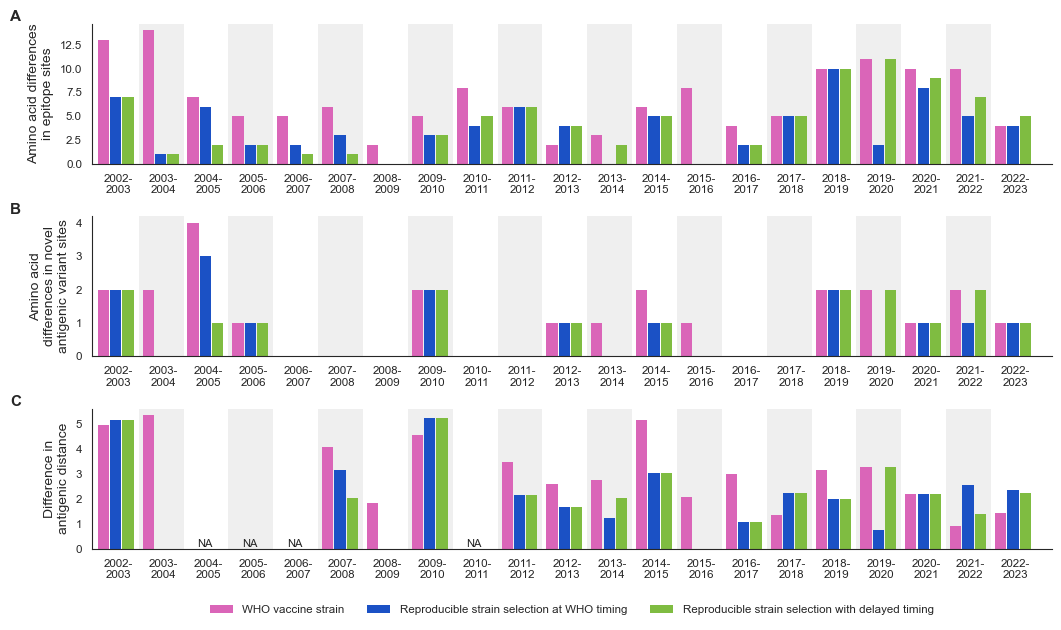

In [19]:
#US 
fig, axes = plt.subplots(3,1, figsize=(12,7), height_ratios=[1,1,1])
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.85, wspace=0.15, hspace=0.375)

cp = ["#da65b8","#1b51c5","#7fbc41"]

for i, comp in enumerate(["n epitope mutations", "n mutations in koel sites", "Antigenic distance"]):
    for j, strain in enumerate(['vaccine strain', 'reproducible selection at WHO-timing', 'reproducible selection at delayed timing']):

        df = supp_table_1.loc[:, [("count", comp, strain)]]
        axes[i].bar(np.arange(len(df))+(0.275*j)-0.275/2, df[("count", comp, strain)], 0.25, label=strain, color=cp[j])

    if comp == "Antigenic distance":
        df = supp_table_1.loc[:, [("count", comp, strain)]]
        for j, season in enumerate(df.index.unique()):
            if len(df.loc[season, :].dropna()) == 0:
                axes[i].text(j-.05, 0, "NA", va="bottom", size=8)

for ax in axes:
    ax.spines[['top','right']].set_visible(False)
    ax.axhline(0, lw=0.5, color="black")
    ax.set_xlim(-.4, len(supp_table_1.index.unique()))

    ax.set_xticks(np.arange(len(supp_table_1.index.unique())) + 0.2, [l.replace("-", "-\n") for l in supp_table_1.index.unique().tolist()])

    if ax==axes[0]:
        ax.set_ylabel('Amino acid differences\nin epitope sites')
    elif ax==axes[1]:
        ax.set_ylabel('Amino acid\ndifferences in novel\nantigenic variant sites')
    else:
        ax.set_ylabel('Difference in\nantigenic distance')

    ax.grid(axis="x", lw=0, c="#efefef", which="major")
    sl = [i+1 for i, season in enumerate(supp_table_1.index.unique().tolist())]
    for x0, x1 in zip(sl[::2], sl[1::2]):
        ax.axvspan(x0-0.35, x1-0.35, color='#efefef', zorder=-2)
                
axes[0].text(-0.085, 1.02, "A", transform=axes[0].transAxes, size=11, weight="bold")
axes[1].text(-0.085, 1.02, "B", transform=axes[1].transAxes, size=11, weight="bold")
axes[2].text(-0.085, 1.02, "C", transform=axes[2].transAxes, size=11, weight="bold")
    
#add legend
leg = axes[2].legend(loc='lower center', ncols=3, bbox_to_anchor=[0.5, -0.55], )
leg.get_texts()[0].set_text('WHO vaccine strain')
leg.get_texts()[1].set_text('Reproducible strain selection at WHO timing')
leg.get_texts()[2].set_text('Reproducible strain selection with delayed timing')


### 3.2. Europe

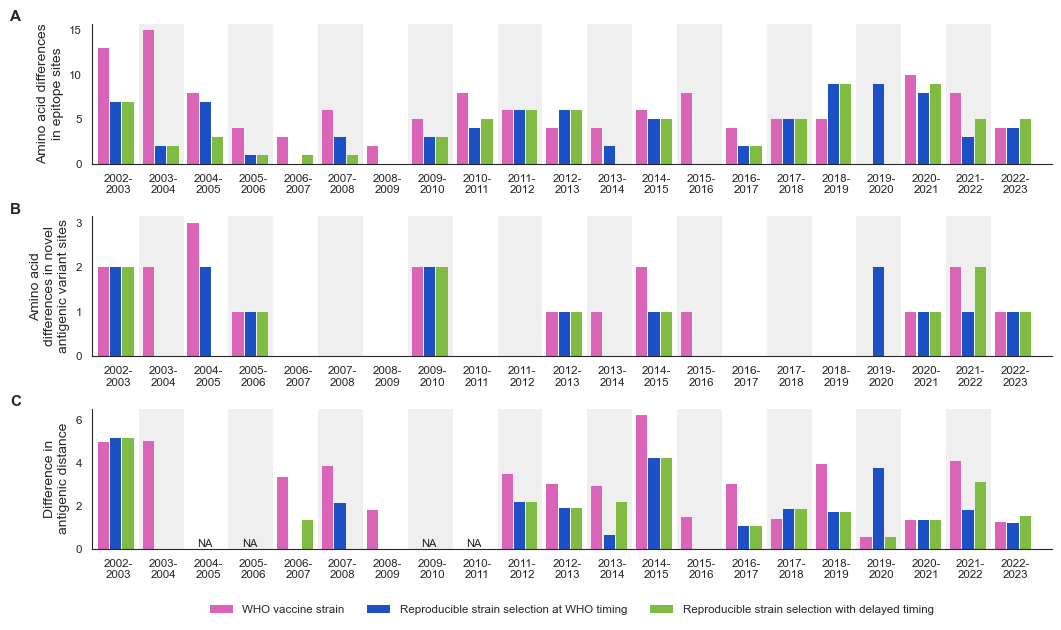

In [20]:
#US 
fig, axes = plt.subplots(3,1, figsize=(12,7), height_ratios=[1,1,1])
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.85, wspace=0.15, hspace=0.375)

cp = ["#da65b8","#1b51c5","#7fbc41"]

for i, comp in enumerate(["n epitope mutations", "n mutations in koel sites", "Antigenic distance"]):
    for j, strain in enumerate(['vaccine strain', 'reproducible selection at WHO-timing', 'reproducible selection at delayed timing']):

        df = supp_table_2.loc[:, [("count", comp, strain)]]
        axes[i].bar(np.arange(len(df))+(0.275*j)-0.275/2, df[("count", comp, strain)], 0.25, label=strain, color=cp[j])

    if comp == "Antigenic distance":
        df = supp_table_2.loc[:, [("count", comp, strain)]]
        for j, season in enumerate(df.index.unique()):
            if len(df.loc[season, :].dropna()) == 0:
                axes[i].text(j-.05, 0, "NA", va="bottom", size=8)

for ax in axes:
    ax.spines[['top','right']].set_visible(False)
    ax.axhline(0, lw=0.5, color="black")
    ax.set_xlim(-.4, len(supp_table_2.index.unique()))

    ax.set_xticks(np.arange(len(supp_table_2.index.unique())) + 0.2, [l.replace("-", "-\n") for l in supp_table_2.index.unique().tolist()])

    if ax==axes[0]:
        ax.set_ylabel('Amino acid differences\nin epitope sites')
    elif ax==axes[1]:
        ax.set_ylabel('Amino acid\ndifferences in novel\nantigenic variant sites')
    else:
        ax.set_ylabel('Difference in\nantigenic distance')

    ax.grid(axis="x", lw=0, c="#efefef", which="major")
    sl = [i+1 for i, season in enumerate(supp_table_2.index.unique().tolist())]
    for x0, x1 in zip(sl[::2], sl[1::2]):
        ax.axvspan(x0-0.35, x1-0.35, color='#efefef', zorder=-2)
                
axes[0].text(-0.085, 1.02, "A", transform=axes[0].transAxes, size=11, weight="bold")
axes[1].text(-0.085, 1.02, "B", transform=axes[1].transAxes, size=11, weight="bold")
axes[2].text(-0.085, 1.02, "C", transform=axes[2].transAxes, size=11, weight="bold")
    
#add legend
leg = axes[2].legend(loc='lower center', ncols=3, bbox_to_anchor=[0.5, -0.55], )
leg.get_texts()[0].set_text('WHO vaccine strain')
leg.get_texts()[1].set_text('Reproducible strain selection at WHO timing')
leg.get_texts()[2].set_text('Reproducible strain selection with delayed timing')


### 3.3. Australia and New Zealand

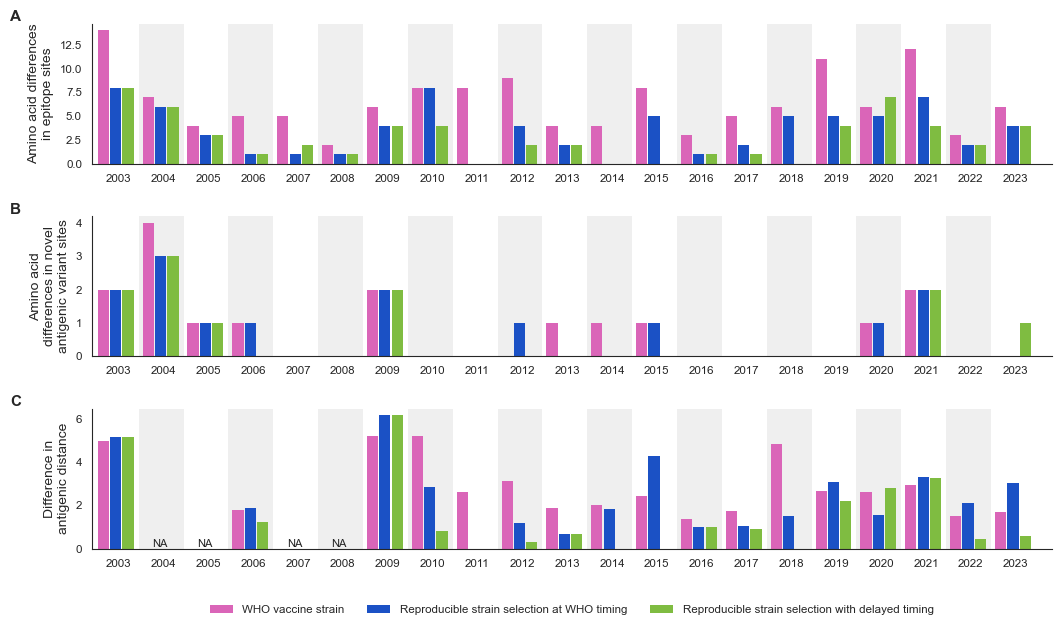

In [21]:
#US 
fig, axes = plt.subplots(3,1, figsize=(12,7), height_ratios=[1,1,1])
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.85, wspace=0.15, hspace=0.375)

cp = ["#da65b8","#1b51c5","#7fbc41"]

for i, comp in enumerate(["n epitope mutations", "n mutations in koel sites", "Antigenic distance"]):
    for j, strain in enumerate(['vaccine strain', 'reproducible selection at WHO-timing', 'reproducible selection at delayed timing']):

        df = supp_table_3.loc[:, [("count", comp, strain)]]
        axes[i].bar(np.arange(len(df))+(0.275*j)-0.275/2, df[("count", comp, strain)], 0.25, label=strain, color=cp[j])

    if comp == "Antigenic distance":
        df = supp_table_3.loc[:, [("count", comp, strain)]]
        for j, season in enumerate(df.index.unique()):
            if len(df.loc[season, :].dropna()) == 0:
                axes[i].text(j-.05, 0, "NA", va="bottom", size=8)

for ax in axes:
    ax.spines[['top','right']].set_visible(False)
    ax.axhline(0, lw=0.5, color="black")
    ax.set_xlim(-.4, len(supp_table_3.index.unique()))

    ax.set_xticks(np.arange(len(supp_table_3.index.unique())) + 0.2, [l.replace("-", "-\n") for l in supp_table_3.index.unique().tolist()])

    if ax==axes[0]:
        ax.set_ylabel('Amino acid differences\nin epitope sites')
    elif ax==axes[1]:
        ax.set_ylabel('Amino acid\ndifferences in novel\nantigenic variant sites')
    else:
        ax.set_ylabel('Difference in\nantigenic distance')

    ax.grid(axis="x", lw=0, c="#efefef", which="major")
    sl = [i+1 for i, season in enumerate(supp_table_3.index.unique().tolist())]
    for x0, x1 in zip(sl[::2], sl[1::2]):
        ax.axvspan(x0-0.35, x1-0.35, color='#efefef', zorder=-2)
                
axes[0].text(-0.085, 1.02, "A", transform=axes[0].transAxes, size=11, weight="bold")
axes[1].text(-0.085, 1.02, "B", transform=axes[1].transAxes, size=11, weight="bold")
axes[2].text(-0.085, 1.02, "C", transform=axes[2].transAxes, size=11, weight="bold")
    
#add legend
leg = axes[2].legend(loc='lower center', ncols=3, bbox_to_anchor=[0.5, -0.55], )
leg.get_texts()[0].set_text('WHO vaccine strain')
leg.get_texts()[1].set_text('Reproducible strain selection at WHO timing')
leg.get_texts()[2].set_text('Reproducible strain selection with delayed timing')
